In [ ]:
import numpy as np
import random
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
import scipy.stats as stats
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [6]:
n = 500
p = 10
lam = 0.4
true_beta = np.zeros(p)
std_noise = 10

X = np.random.normal(0, 1, size=(n, p))
X = X - np.mean(X, axis=0)
for j in range(p):
    X[:, j] /= np.linalg.norm(X[:, j]) / np.sqrt(n)


In [7]:

def create_data(X, true_beta, intercept=0, std_noise=1):
    n = X.shape[0]
    linear_component = X @ true_beta
    noise = np.random.normal(0, std_noise, size=n)
    y = linear_component + noise + intercept
    return y.reshape(-1, 1)

def fit_lasso_model(X, y, lam, max_iter=10000, tol=1e-7):
    def soft_thresolding(rho, lam_val):
        if rho < -lam_val: return rho + lam_val
        elif rho > lam_val: return rho - lam_val
        else: return 0
    n, p = X.shape
    y_flat = y.flatten()
    beta = np.zeros(p)
    intercept = np.mean(y_flat)
    residual = y_flat - (X @ beta + intercept)
    for _ in range(max_iter):
        beta_old = beta.copy()
        intercept = np.mean(y_flat - X @ beta)
        residual = y_flat - (X @ beta + intercept)
        for j in range(p):
            r_j = residual + X[:, j] * beta[j]
            rho_j = (X[:, j] @ r_j) / n
            beta[j] = soft_thresolding(rho_j, lam)
            residual = y_flat - (X @ beta + intercept)
        if np.linalg.norm(beta - beta_old, ord=1) < tol: break
    return beta, intercept


In [8]:

def basic_parameter(X, active_set, y, std_noise):
    n, p = X.shape
    p_active = len(active_set)
    if p_active == 0: return [None]*5
    X_active = X[:, active_set]
    choice_idx_in_active_set = random.randint(0, p_active - 1)
    chosen_variable_index = active_set[choice_idx_in_active_set]
    e_j = np.zeros(p_active)
    e_j[choice_idx_in_active_set] = 1
    try:
        X_plus = np.linalg.inv(X_active.T @ X_active) @ X_active.T
    except np.linalg.LinAlgError:
        return [None]*5
    eta = (X_plus.T @ e_j).reshape(-1, 1)
    covariance_matrix = np.diag([std_noise ** 2] * n)
    c = covariance_matrix @ eta @ np.linalg.inv(eta.T @ covariance_matrix @ eta + 1e-8)
    identity_n = np.identity(n)
    z = (identity_n - c @ eta.T) @ y
    return eta, c, z, covariance_matrix, chosen_variable_index

def compute_polyhedron_interval(X, active_set, s, z, c, lam):
    n, p = X.shape
    if len(active_set) == 0: return None, None
    non_active_set = np.setdiff1d(np.arange(p), active_set)
    X_active = X[:, active_set]; X_nonactive = X[:, non_active_set]
    s = np.array(s)
    try: inv_XtX = np.linalg.inv(X_active.T @ X_active)
    except np.linalg.LinAlgError: return None, None
    X_plus = inv_XtX @ X_active.T
    proj = X_active @ X_plus; id_n = np.identity(n)
    if len(non_active_set) == 0: A_0, b_0 = np.empty((0, n)), np.empty((0, 1))
    else:
        A_0_h = X_nonactive.T @ (id_n - proj)
        A_0 = (1 / (n*lam)) * np.vstack([A_0_h, -A_0_h])
        b_0_h = (X_nonactive.T @ X_plus.T @ s).reshape(-1, 1)
        b_0 = np.vstack([1 - b_0_h, 1 + b_0_h])
    A_1 = -np.diag(s) @ X_plus
    b_1_f = -(n * lam) * (np.diag(s) @ inv_XtX @ s)
    b_1 = b_1_f.reshape(-1, 1)
    A = np.vstack([A_0, A_1]); b = np.vstack([b_0, b_1])
    Az, Ac = A @ z, A @ c
    v_minus, v_plus = float('-inf'), float('inf')
    for i in range(A.shape[0]):
        ac_i, az_i, b_i = Ac[i, 0], Az[i, 0], b[i, 0]
        if ac_i > 1e-9: v_plus = min(v_plus, (b_i - az_i) / ac_i)
        elif ac_i < -1e-9: v_minus = max(v_minus, (b_i - az_i) / ac_i)
        elif az_i > b_i + 1e-9: return None, None
    if v_minus > v_plus + 1e-7: return None, None
    return v_minus, v_plus

def merge_intervals(intervals):
    if not intervals: return []
    intervals.sort(key=lambda x: x[0])
    merged = [intervals[0]]
    for cur_s, cur_e in intervals[1:]:
        _, last_e = merged[-1]
        if cur_s <= last_e + 1e-7: merged[-1] = (merged[-1][0], max(last_e, cur_e))
        else: merged.append((cur_s, cur_e))
    return merged

def p_value_on_model(observed_stat, mu, std, V_list):
    if std < 1e-9 or not V_list: return None
    obs = observed_stat.item()
    total_prob = 0
    for v_min, v_plus in V_list: total_prob += norm.cdf(v_plus, mu, std) - norm.cdf(v_min, mu, std)
    if total_prob < 1e-9: return 1.0
    tail_prob = 0
    for v_min, v_plus in V_list:
        low_b = max(v_min, obs)
        if low_b < v_plus: tail_prob += norm.cdf(v_plus, mu, std) - norm.cdf(low_b, mu, std)
    return tail_prob / total_prob



In [9]:


def solve(X, true_beta, std_noise, lam, verbose=False):
    y_observed = create_data(X, true_beta, 0, std_noise)
    beta_hat, _ = fit_lasso_model(X, y_observed, lam)
    active_set_obs = np.where(np.abs(beta_hat) > 1e-6)[0]

    if len(active_set_obs) == 0:
        if verbose: print("Mô hình không chọn biến nào.")
        return None, None, None

    eta, c, z, sigma, chosen_var = basic_parameter(X, active_set_obs, y_observed, std_noise)
    if eta is None: return None, None, None

    std_stat = np.sqrt((eta.T @ sigma @ eta).item())
    bound = 20 * std_stat
    epsilon = 1e-4
    small_step = bound / 200

    current_v = -bound
    discovered_intervals = []
    
    while current_v < bound:
        y_prime = z + c * current_v
        beta_prime, _ = fit_lasso_model(X, y_prime, lam)
        active_set_prime = np.where(np.abs(beta_prime) > 1e-6)[0]
        
        if np.array_equal(active_set_prime, active_set_obs):
            s_prime = np.sign(beta_prime[active_set_prime])
            v_min, v_plus = compute_polyhedron_interval(X, active_set_obs, s_prime, z, c, lam)
            if v_min is not None:
                discovered_intervals.append((v_min, v_plus))
                current_v = v_plus + epsilon
            else:
                current_v += small_step
        else:
            current_v += small_step

    V_list_merged = merge_intervals(discovered_intervals)
    observed_stat = eta.T @ y_observed
    p_val = p_value_on_model(observed_stat, 0, std_stat, V_list_merged)
    print(1)
    return p_val, chosen_var, true_beta[chosen_var]


  0%|          | 0/5000 [00:00<?, ?it/s]

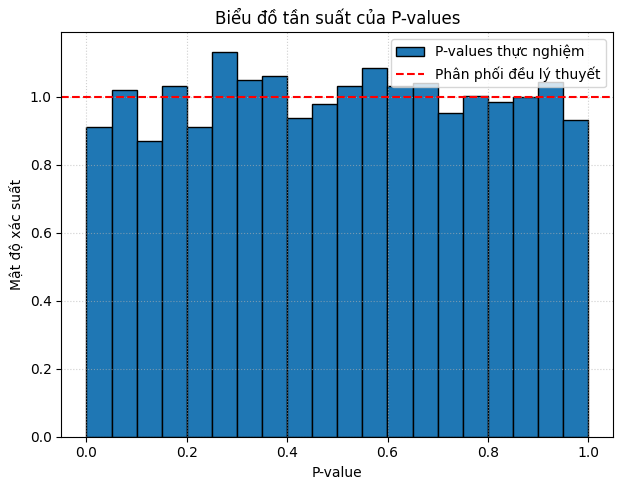

In [14]:

def plot_results(p_values_null):
    if not p_values_null:
        print("Không có p-value nào của biến null để vẽ đồ thị.")
        return

    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 1. Biểu đồ Histogram
    axes[0].hist(p_values_null, bins=20, density=True, edgecolor='black', label='P-values thực nghiệm')
    axes[0].axhline(y=1.0, color='r', linestyle='--', label='Phân phối đều lý thuyết')
    axes[0].set_title('Biểu đồ tần suất của P-values')
    axes[0].set_xlabel('P-value')
    axes[0].set_ylabel('Mật độ xác suất')
    axes[0].legend()
    axes[0].grid(True, linestyle=':', alpha=0.6)

    plt.delaxes(axes[1])
    plt.tight_layout()
    plt.show()
def run_single_simulation(_):
    p_val, var_idx, true_val = solve(X, true_beta, std_noise, lam)
    return (p_val, var_idx, true_val)
def main(num_runs=200):
    p_values_null = []
    p_values_non_null = []

    # for i in tqdm(range(num_runs), desc="Chạy mô phỏng"):
    #     p_val, var_idx, true_val = solve(X, true_beta, std_noise, lam)
        


    result = Parallel(n_jobs=10)(delayed(solve)(X, true_beta, std_noise, lam) for _ in tqdm(range(num_runs)))
    for p_val, var_idx, true_val in result:
        if p_val is not None:
            if abs(true_val) < 1e-6: 
                p_values_null.append(p_val)
            else: 
                p_values_non_null.append(p_val)
    plot_results(p_values_null)

main(5000)